In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# Import frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

import torch
import torch.nn as nn
import torch.optim as optim

print("XOR MLP - UNIFIED IMPLEMENTATION")
print("Comparing Keras, PyTorch, and TensorFlow Low-Level API")

XOR MLP - UNIFIED IMPLEMENTATION
Comparing Keras, PyTorch, and TensorFlow Low-Level API


In [ ]:
# DATASET PREPARATION

print("DATASET PREPARATION")


X_np = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
y_np = np.array([[0], [1], [1], [0]], dtype=np.float32)

print("\nXOR Truth Table:")
print("-" * 30)
for i in range(len(X_np)):
    print(f"Input: {X_np[i]} → Output: {int(y_np[i][0])}")

DATASET PREPARATION

XOR Truth Table:
------------------------------
Input: [0. 0.] → Output: 0
Input: [0. 1.] → Output: 1
Input: [1. 0.] → Output: 1
Input: [1. 1.] → Output: 0


In [ ]:
# Convert to framework-specific formats
X_keras = X_np
y_keras = y_np

X_pytorch = torch.FloatTensor(X_np)
y_pytorch = torch.FloatTensor(y_np)

X_tf = tf.constant(X_np)
y_tf = tf.constant(y_np)

In [ ]:


print("MODEL ARCHITECTURES")


# KERAS MODEL
print("\n[1] KERAS MODEL")


def create_keras_model(hidden_neurons=4, learning_rate=0.1):
    model = keras.Sequential([
        layers.Dense(hidden_neurons, activation='relu', input_shape=(2,), name='hidden'),
        layers.Dense(1, activation='sigmoid', name='output')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model_keras = create_keras_model()
model_keras.summary()

# PYTORCH MODEL
print("\n[2] PYTORCH MODEL")


class PyTorchXOR(nn.Module):
    def __init__(self, hidden_neurons=4):
        super(PyTorchXOR, self).__init__()
        self.hidden = nn.Linear(2, hidden_neurons)
        self.output = nn.Linear(hidden_neurons, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

model_pytorch = PyTorchXOR(hidden_neurons=4)
print(model_pytorch)

criterion_pytorch = nn.BCELoss()
optimizer_pytorch = optim.Adam(model_pytorch.parameters(), lr=0.1)

# TENSORFLOW LOW-LEVEL MODEL
print("\n[3] TENSORFLOW LOW-LEVEL MODEL")


class TensorFlowXOR:
    def __init__(self, hidden_neurons=4, learning_rate=0.1):
        self.W1 = tf.Variable(tf.random.normal([2, hidden_neurons], stddev=0.5))
        self.b1 = tf.Variable(tf.zeros([hidden_neurons]))
        self.W2 = tf.Variable(tf.random.normal([hidden_neurons, 1], stddev=0.5))
        self.b2 = tf.Variable(tf.zeros([1]))
        self.optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    def forward(self, X):
        hidden = tf.nn.relu(tf.matmul(X, self.W1) + self.b1)
        output = tf.nn.sigmoid(tf.matmul(hidden, self.W2) + self.b2)
        return output

    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            predictions = self.forward(X)
            loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y, predictions))

        gradients = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2])
        self.optimizer.apply_gradients(zip(gradients, [self.W1, self.b1, self.W2, self.b2]))
        return loss

model_tf = TensorFlowXOR(hidden_neurons=4, learning_rate=0.1)
print(f"Hidden Layer: Weights shape {model_tf.W1.shape}")
print(f"Output Layer: Weights shape {model_tf.W2.shape}")

MODEL ARCHITECTURES

[1] KERAS MODEL


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17 (68.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)


[2] PYTORCH MODEL
PyTorchXOR(
  (hidden): Linear(in_features=2, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

[3] TENSORFLOW LOW-LEVEL MODEL
Hidden Layer: Weights shape (2, 4)
Output Layer: Weights shape (4, 1)


In [ ]:
# TRAINING

print("TRAINING ALL MODELS")


epochs = 1000
print(f"\nTraining for {epochs} epochs...\n")

# Storage for metrics
history = {
    'keras': {'loss': [], 'accuracy': [], 'time': 0},
    'pytorch': {'loss': [], 'accuracy': [], 'time': 0},
    'tensorflow': {'loss': [], 'accuracy': [], 'time': 0}
}

# Training loop
for epoch in range(epochs):

    #KERAS TRAINING
    start_time = time.time()
    keras_history = model_keras.fit(X_keras, y_keras, epochs=1, verbose=0)
    history['keras']['loss'].append(keras_history.history['loss'][0])
    history['keras']['accuracy'].append(keras_history.history['accuracy'][0])
    history['keras']['time'] += time.time() - start_time

    #PYTORCH TRAINING
    start_time = time.time()
    optimizer_pytorch.zero_grad()
    outputs_pytorch = model_pytorch(X_pytorch)
    loss_pytorch = criterion_pytorch(outputs_pytorch, y_pytorch)
    loss_pytorch.backward()
    optimizer_pytorch.step()

    predicted_pytorch = (outputs_pytorch > 0.5).float()
    accuracy_pytorch = (predicted_pytorch == y_pytorch).float().mean()

    history['pytorch']['loss'].append(loss_pytorch.item())
    history['pytorch']['accuracy'].append(accuracy_pytorch.item())
    history['pytorch']['time'] += time.time() - start_time

    #TENSORFLOW TRAINING
    start_time = time.time()
    loss_tf = model_tf.train_step(X_tf, y_tf)

    predictions_tf = model_tf.forward(X_tf)
    predicted_tf = tf.cast(predictions_tf > 0.5, tf.float32)
    accuracy_tf = tf.reduce_mean(tf.cast(tf.equal(predicted_tf, y_tf), tf.float32))

    history['tensorflow']['loss'].append(loss_tf.numpy())
    history['tensorflow']['accuracy'].append(accuracy_tf.numpy())
    history['tensorflow']['time'] += time.time() - start_time

    # Print progress
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:4d}/{epochs}")
        print(f"  Keras      - Loss: {history['keras']['loss'][-1]:.4f}, Acc: {history['keras']['accuracy'][-1]:.4f}")
        print(f"  PyTorch    - Loss: {history['pytorch']['loss'][-1]:.4f}, Acc: {history['pytorch']['accuracy'][-1]:.4f}")
        print(f"  TensorFlow - Loss: {history['tensorflow']['loss'][-1]:.4f}, Acc: {history['tensorflow']['accuracy'][-1]:.4f}")
        print()

print("\nTraining Complete!")
print(f"\nTraining Time Comparison:")
print(f"  Keras:      {history['keras']['time']:.3f} seconds")
print(f"  PyTorch:    {history['pytorch']['time']:.3f} seconds")
print(f"  TensorFlow: {history['tensorflow']['time']:.3f} seconds")

TRAINING ALL MODELS

Training for 1000 epochs...

Epoch    1/1000
  Keras      - Loss: 0.7262, Acc: 0.5000
  PyTorch    - Loss: 0.7100, Acc: 0.5000
  TensorFlow - Loss: 0.6961, Acc: 0.5000

Epoch  200/1000
  Keras      - Loss: 0.3468, Acc: 0.7500
  PyTorch    - Loss: 0.0025, Acc: 1.0000
  TensorFlow - Loss: 0.4775, Acc: 0.7500

Epoch  400/1000
  Keras      - Loss: 0.3466, Acc: 0.7500
  PyTorch    - Loss: 0.0009, Acc: 1.0000
  TensorFlow - Loss: 0.4776, Acc: 0.7500

Epoch  600/1000
  Keras      - Loss: 0.3466, Acc: 0.7500
  PyTorch    - Loss: 0.0005, Acc: 1.0000
  TensorFlow - Loss: 0.4774, Acc: 0.7500

Epoch  800/1000
  Keras      - Loss: 0.3466, Acc: 0.7500
  PyTorch    - Loss: 0.0003, Acc: 1.0000
  TensorFlow - Loss: 0.4774, Acc: 0.7500

Epoch 1000/1000
  Keras      - Loss: 0.3466, Acc: 0.7500
  PyTorch    - Loss: 0.0002, Acc: 1.0000
  TensorFlow - Loss: 0.4774, Acc: 0.7500


Training Complete!

Training Time Comparison:
  Keras:      112.312 seconds
  PyTorch:    2.420 seconds
  Ten

In [ ]:
# EVALUATION
print("MODEL EVALUATION - PREDICTIONS COMPARISON")


# Get predictions from all models
pred_keras = model_keras.predict(X_keras, verbose=0)
pred_pytorch = model_pytorch(X_pytorch).detach().numpy()
pred_tf = model_tf.forward(X_tf).numpy()

print("\n{:<15} {:<10} {:<20} {:<20} {:<20}".format(
    "Input", "Expected", "Keras", "PyTorch", "TensorFlow"))


for i in range(len(X_np)):
    input_str = f"[{X_np[i][0]:.0f}, {X_np[i][1]:.0f}]"
    expected = int(y_np[i][0])

    keras_val = pred_keras[i][0]
    keras_round = int(keras_val > 0.5)
    keras_symbol = "✓" if keras_round == expected else "✗"

    pytorch_val = pred_pytorch[i][0]
    pytorch_round = int(pytorch_val > 0.5)
    pytorch_symbol = "✓" if pytorch_round == expected else "✗"

    tf_val = pred_tf[i][0]
    tf_round = int(tf_val > 0.5)
    tf_symbol = "✓" if tf_round == expected else "✗"

    print(f"{input_str:<15} {expected:<10} {keras_symbol} {keras_val:.4f} ({keras_round}){' '*7} "
          f"{pytorch_symbol} {pytorch_val:.4f} ({pytorch_round}){' '*5} "
          f"{tf_symbol} {tf_val:.4f} ({tf_round})")

# Final metrics
print("FINAL PERFORMANCE METRICS")

final_metrics = []
for framework in ['keras', 'pytorch', 'tensorflow']:
    final_loss = history[framework]['loss'][-1]
    final_acc = history[framework]['accuracy'][-1]
    train_time = history[framework]['time']
    final_metrics.append([framework.capitalize(), final_loss, final_acc, train_time])

print("\n{:<15} {:<15} {:<15} {:<15}".format("Framework", "Final Loss", "Final Accuracy", "Training Time"))

for metric in final_metrics:
    print(f"{metric[0]:<15} {metric[1]:<15.4f} {metric[2]:<15.4f} {metric[3]:<15.3f}s")

MODEL EVALUATION - PREDICTIONS COMPARISON

Input           Expected   Keras                PyTorch              TensorFlow          
[0, 0]          0          ✓ 0.5000 (0)        ✓ 0.0004 (0)      ✓ 0.3333 (0)
[0, 1]          1          ✓ 1.0000 (1)        ✓ 1.0000 (1)      ✓ 1.0000 (1)
[1, 0]          1          ✗ 0.5000 (0)        ✓ 1.0000 (1)      ✗ 0.3333 (0)
[1, 1]          0          ✓ 0.0000 (0)        ✓ 0.0004 (0)      ✓ 0.3333 (0)
FINAL PERFORMANCE METRICS

Framework       Final Loss      Final Accuracy  Training Time  
Keras           0.3466          0.7500          112.312        s
Pytorch         0.0002          1.0000          2.420          s
Tensorflow      0.4774          0.7500          30.910         s


GENERATING VISUALIZATIONS

✓ Comparison plot saved to: results/unified_comparison.png
✓ Detailed metrics plot saved to: results/detailed_training_metrics.png


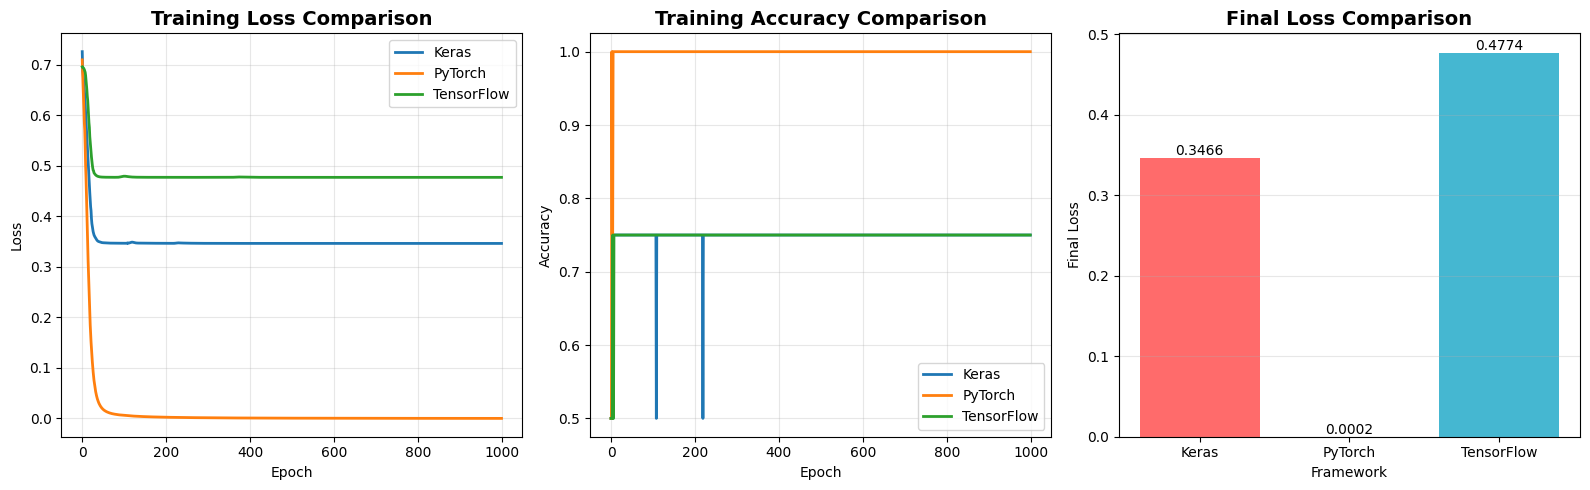

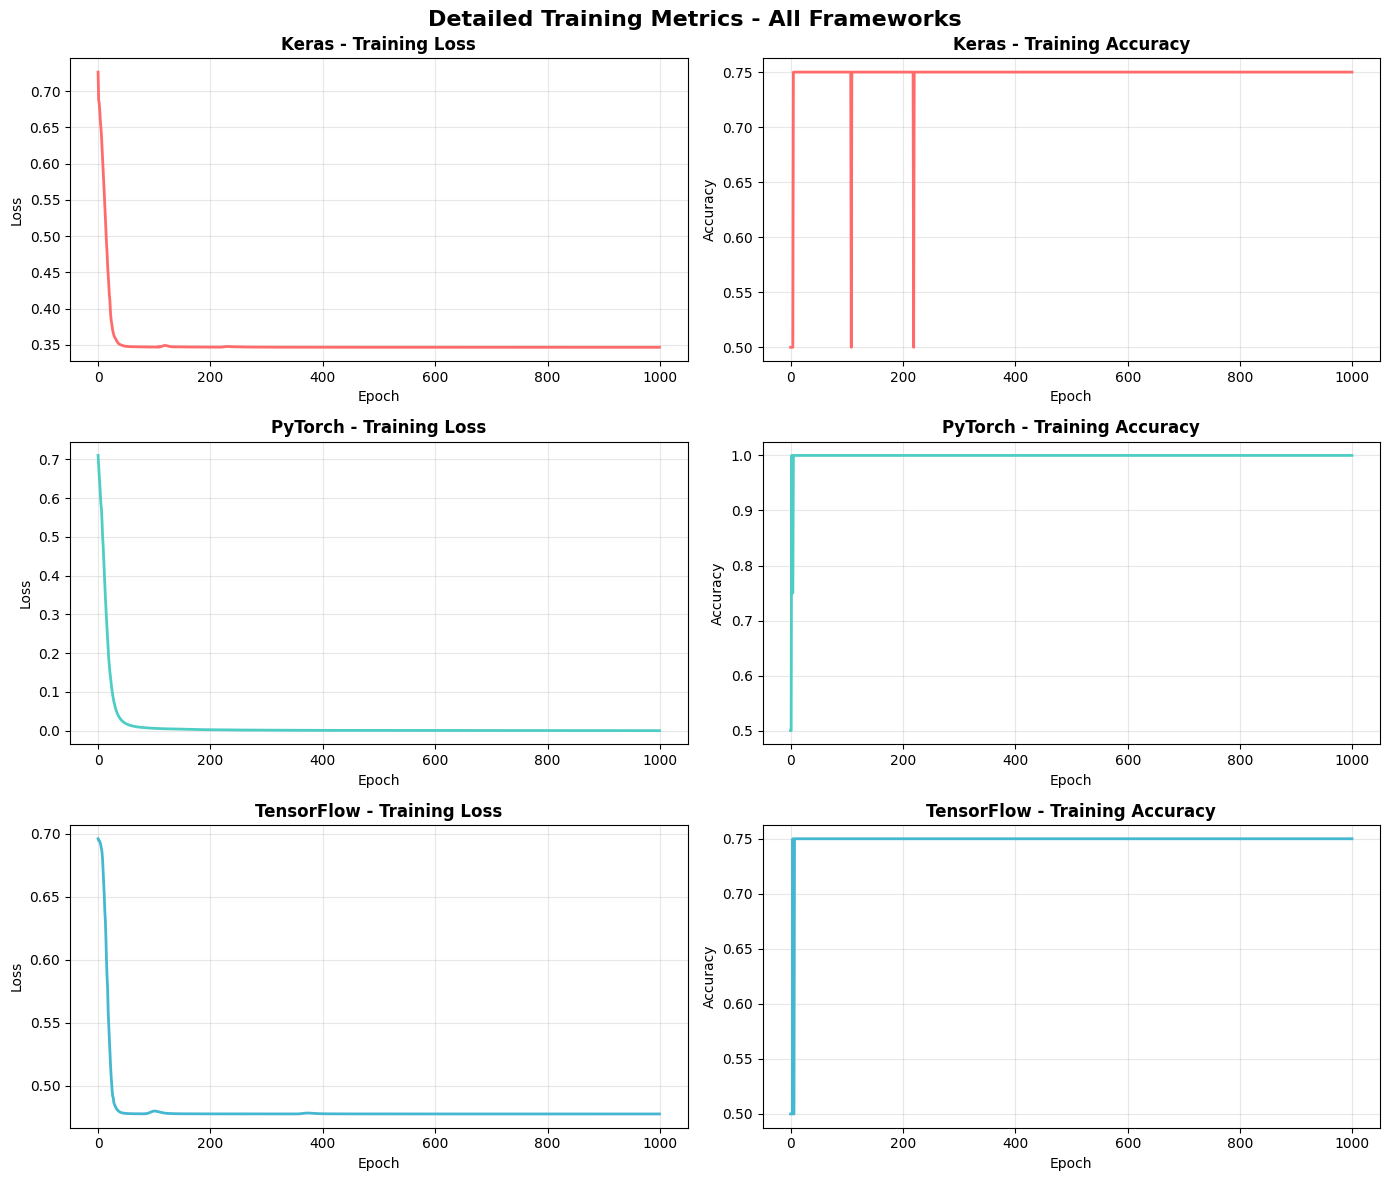

In [ ]:
# VISUALIZATION
print("GENERATING VISUALIZATIONS")


# Create results directory
if not os.path.exists('results'):
    os.makedirs('results')

# Plot 1: Loss Comparison
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(history['keras']['loss'], label='Keras', linewidth=2)
plt.plot(history['pytorch']['loss'], label='PyTorch', linewidth=2)
plt.plot(history['tensorflow']['loss'], label='TensorFlow', linewidth=2)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy Comparison
plt.subplot(1, 3, 2)
plt.plot(history['keras']['accuracy'], label='Keras', linewidth=2)
plt.plot(history['pytorch']['accuracy'], label='PyTorch', linewidth=2)
plt.plot(history['tensorflow']['accuracy'], label='TensorFlow', linewidth=2)
plt.title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final Metrics Bar Chart
plt.subplot(1, 3, 3)
frameworks = ['Keras', 'PyTorch', 'TensorFlow']
final_losses = [history['keras']['loss'][-1],
                history['pytorch']['loss'][-1],
                history['tensorflow']['loss'][-1]]
x_pos = np.arange(len(frameworks))
bars = plt.bar(x_pos, final_losses, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Framework')
plt.ylabel('Final Loss')
plt.title('Final Loss Comparison', fontsize=14, fontweight='bold')
plt.xticks(x_pos, frameworks)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('results/unified_comparison.png', dpi=150, bbox_inches='tight')
print("\n✓ Comparison plot saved to: results/unified_comparison.png")

# Plot 4: Individual Framework Plots
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Detailed Training Metrics - All Frameworks', fontsize=16, fontweight='bold')

frameworks_list = ['keras', 'pytorch', 'tensorflow']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
titles = ['Keras', 'PyTorch', 'TensorFlow']

for idx, (framework, color, title) in enumerate(zip(frameworks_list, colors, titles)):
    # Loss plot
    axes[idx, 0].plot(history[framework]['loss'], color=color, linewidth=2)
    axes[idx, 0].set_title(f'{title} - Training Loss', fontweight='bold')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss')
    axes[idx, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[idx, 1].plot(history[framework]['accuracy'], color=color, linewidth=2)
    axes[idx, 1].set_title(f'{title} - Training Accuracy', fontweight='bold')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('Accuracy')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/detailed_training_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Detailed metrics plot saved to: results/detailed_training_metrics.png")

plt.show()

In [ ]:
# HYPERPARAMETER EXPERIMENTS

print("HYPERPARAMETER EXPERIMENTATION")


def run_experiment(hidden_neurons=4, learning_rate=0.1, epochs=1000):


    # Keras
    model_k = create_keras_model(hidden_neurons, learning_rate)
    hist_k = model_k.fit(X_keras, y_keras, epochs=epochs, verbose=0)

    # PyTorch
    model_p = PyTorchXOR(hidden_neurons)
    criterion_p = nn.BCELoss()
    optimizer_p = optim.Adam(model_p.parameters(), lr=learning_rate)

    for _ in range(epochs):
        optimizer_p.zero_grad()
        outputs = model_p(X_pytorch)
        loss = criterion_p(outputs, y_pytorch)
        loss.backward()
        optimizer_p.step()

    pred_p = model_p(X_pytorch).detach().numpy()
    acc_p = np.mean((pred_p > 0.5) == y_np)

    # TensorFlow
    model_t = TensorFlowXOR(hidden_neurons, learning_rate)
    for _ in range(epochs):
        model_t.train_step(X_tf, y_tf)

    pred_t = model_t.forward(X_tf).numpy()
    acc_t = np.mean((pred_t > 0.5) == y_np)

    return {
        'keras': hist_k.history['accuracy'][-1],
        'pytorch': acc_p,
        'tensorflow': acc_t
    }

# Exp 1: Different Hidden Neurons
print("\n--- Experiment 1: Number of Hidden Neurons ---")
print(f"{'Neurons':<10} {'Keras':<15} {'PyTorch':<15} {'TensorFlow':<15}")


for neurons in [2, 4, 8, 16]:
    results = run_experiment(hidden_neurons=neurons, learning_rate=0.1, epochs=1000)
    print(f"{neurons:<10} {results['keras']:<15.4f} {results['pytorch']:<15.4f} {results['tensorflow']:<15.4f}")

# Exp 2: Different Learning Rates
print("\n--- Experiment 2: Learning Rate ---")
print(f"{'LR':<10} {'Keras':<15} {'PyTorch':<15} {'TensorFlow':<15}")


for lr in [0.01, 0.05, 0.1, 0.5]:
    results = run_experiment(hidden_neurons=4, learning_rate=lr, epochs=1000)
    print(f"{lr:<10.2f} {results['keras']:<15.4f} {results['pytorch']:<15.4f} {results['tensorflow']:<15.4f}")

HYPERPARAMETER EXPERIMENTATION

--- Experiment 1: Number of Hidden Neurons ---
Neurons    Keras           PyTorch         TensorFlow     


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2          1.0000          0.7500          1.0000         
4          0.7500          0.7500          1.0000         
8          1.0000          1.0000          1.0000         
16         1.0000          1.0000          1.0000         

--- Experiment 2: Learning Rate ---
LR         Keras           PyTorch         TensorFlow     
0.01       1.0000          1.0000          1.0000         
0.05       0.7500          1.0000          1.0000         
0.10       0.7500          1.0000          0.5000         
0.50       1.0000          0.5000          1.0000         
